In [2]:
import numpy as np
import scipy as sp
from qutip import *
from qutip.qip.circuit import QubitCircuit, Gate
from qutip.qip.operations import *
from cvqaoa.cvdevice import KPOProcessor
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
from cvqaoa.plotlib import plotlib
plotlib.update_settings(usetex=True)
%config InlineBackend.figure_format = 'svg'

/Users/turbotanten/Documents/GitHub/cvqaoa/.env/lib/python3.9/site-packages/matplotlib_inline/config.py:75: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


# Single Ising Spin

In [77]:
num_lvl = 20 # Hilbert space cut-off
a = destroy(num_lvl) # Annihilation operator
eye = qeye(num_lvl) # Identity operator

## Parameters
K = 1 # Kerr amplitude
G = 4 # Two-photon drive amplitude (in units of K)
alpha = np.sqrt(G/K) # Coherent state amplitude
Delta = 1/(alpha**2 * np.exp(-2*alpha**2)) # Detuning (in units of K)
E = 1 / (2*alpha)

# Cat state
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

# Computational basis
up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

# Pauli Matrices in computational basis
# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())
# List with Paulis
sigma = [sigma_x, sigma_y, sigma_z]

In [50]:
import time
H0 = - Delta*a.dag()*a - K*a.dag()**2*a**2
H1 = - K*a.dag()**2*a**2 + G*(a.dag()**2 + a**2) + E*(a.dag() + a)

HC = ket2dm(coherent(num_lvl,alpha)) - ket2dm(coherent(num_lvl,-alpha))

# Initialstate
initial_state = basis(num_lvl,0)

def variational_state(x:tuple):
    s = initial_state
    alphas, betas = x
    for alpha, beta in zip(alphas,betas):
        s = (-1j*H0*beta).expm() * (-1j*H1*alpha).expm() * s
    return s

def expval(x):
    p = int(len(x)/2)
    alphas = tuple(x[:p])
    betas = tuple(x[p:])
    x = (alphas,betas)
    return expect(sigma_z,variational_state(x))

### Find the optimal angles

In [53]:
ranges = ((0, np.pi), (0, np.pi))
res = sp.optimize.brute(expval, ranges, Ns=200, full_output=True, finish=sp.optimize.fmin)

In [78]:
X = res[2][0]
Y = res[2][1]
Z = res[3]

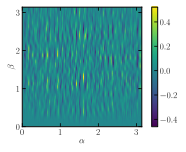

In [79]:
"""Save a figure"""
fig, ax = plotlib.create_fig(single_col=True,nrows=1)

im = ax.imshow(Z,
              interpolation ='nearest',
              origin ='lower',
              extent=[X.min(), X.max(), Y.min(), Y.max()]);

fig.colorbar(im);
ax.set_xlabel(r"$\alpha$");
ax.set_ylabel(r"$\beta$");
#ax.set_xlim([0.8,6.2]);
#ax.set_ylabel("mean approx. ratio");
#ax.set_xlabel("qaoa level");
#ax.set_ylim([0.75,1]);
#fig.savefig("../../figures/fig-landscape.pdf",bbox_inches='tight');

### Compute the success probability

In [69]:
alpha, beta = res[0]
final_state = variational_state(((alpha,),(beta,)))

In [74]:
fidelity(final_state,down)

0.763908727353157

### Compute the fidelity

In [60]:
lvl = 1
alphas = tuple(res[0][:lvl])
betas = tuple(res[0][lvl:])
x = (alphas,betas)
s = variational_state(x)
# Compute the success probability
fidelity(s,down)

0.7440618263661719

# Cat State

In [90]:
N = 20 # Hilbert space cut-off
a = destroy(N) # Annihilation operator
eye = qeye(N) # Identity operator

## Parameters
K = 1 # Kerr amplitude
G = 4 # Two-photon drive amplitude (in units of K)
alpha = np.sqrt(G/K) # Coherent state amplitude
Delta = 1/(alpha**2 * np.exp(-2*alpha**2)) # Detuning (in units of K)

H0 = - Delta*a.dag()*a - K*a.dag()**2*a**2
H1 = - K*a.dag()**2*a**2 + G*(a.dag()**2 + a**2)

# Initialstate
initial_state = basis(N,0)

# Cat state
cat_plus = (coherent(N,alpha) + coherent(N,-alpha)).unit()

def variational_state(x:tuple):
    s = initial_state
    alphas, betas = x
    for alpha, beta in zip(alphas,betas):
        s = (-1j*H0*beta).expm() * (-1j*H1*alpha).expm() * s
    return s
    
def expval(x):
    p = int(len(x)/2)
    alphas = tuple(x[:p])
    betas = tuple(x[p:])
    x = (alphas,betas)
    return (1-fidelity(variational_state(x), cat_plus)**2)

### Optimize

In [91]:
ranges = ((0, np.pi), (0, np.pi))
res = sp.optimize.brute(expval, ranges, Ns=200, full_output=True, finish=sp.optimize.fmin)

In [92]:
X = res[2][0]
Y = res[2][1]
Z = res[3]

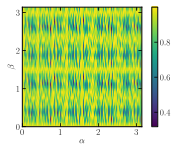

In [93]:
"""Save a figure"""
fig, ax = plotlib.create_fig(single_col=True,nrows=1)

im = ax.imshow(Z, 
              interpolation ='nearest', 
              origin ='lower',
              extent=[X.min(), X.max(), Y.min(), Y.max()]);

fig.colorbar(im)
ax.set_xlabel(r"$\alpha$");
ax.set_ylabel(r"$\beta$");
#ax.set_xticks([0,np.pi/2],['0',r'$\pi/2$'])
#ax.set_xlim([0.8,6.2]);
#ax.set_ylabel("mean approx. ratio")
#ax.set_xlabel("qaoa level")
#ax.set_ylim([0.75,1]);

In [99]:
fig.savefig("../../figures/fig-landscape-cat.pdf",bbox_inches='tight')

In [95]:
alpha, beta = res[0]

In [100]:
xvec = np.linspace(-4, 4, 400); yvec = np.linspace(-2, 2, 200)
state = variational_state(([alpha],[beta]))
W = wigner(state,xvec,yvec,'iterative',2)
nrm = mpl.colors.Normalize(-W.max(), W.max()) # Normalize colors

# contour plot
plt.subplot(121,aspect='equal')
im = plt.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

cat_plus = (coherent(N,alpha) + coherent(N,-alpha)).unit()
print(fidelity(state,cat_plus)**2)

0.5772219496468736
